# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

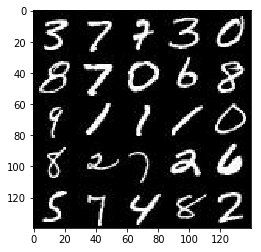

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 'L', 28, 28)
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

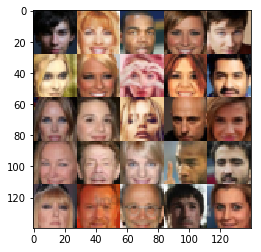

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 'RGB', 28, 28)
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(dtype=tf.float32, 
                             shape=(None, image_width, image_height, image_channels),
                             name='input_real')
    input_z = tf.placeholder(dtype=tf.float32, 
                             shape=(None, z_dim), 
                             name='input_z')
    learning_rate = tf.placeholder(dtype=tf.float32, shape=(), name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Leak factor
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):   
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2, padding='same')
        relu1 = tf.maximum(alpha* x1, x1)
        
        x2 = tf.layers.conv2d(relu1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, filters=256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Leak factor
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train): 
        h = tf.layers.dense(z, 7 * 7 * 1024)
        
        x1 = tf.reshape(h, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * x1, x1)
                
        x2 = tf.layers.conv2d_transpose(relu1, filters=256, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(relu2, filters=128, kernel_size=5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')       
        out = tf.tanh(logits)                              
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smoothing = 0.1

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_model_real) * (1 - smoothing)
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)
        )
    )
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)
        )
    )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    g_vars = [x for x in t_vars if x.name.startswith('generator')]
    d_vars = [x for x in t_vars if x.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
print_every = 10
show_every = 100

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, width, height, channels = data_shape
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Get images and rescale to pass to D
                batch_images = batch_images * 2
                
                # Sample rndom noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={input_real: batch_images,
                                              input_z: batch_z,
                                              lr: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images,
                                             input_z: batch_z,
                                             lr: learning_rate})
                
                steps += 1
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6190... Generator Loss: 2.6645
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 3.0403
Epoch 1/2... Discriminator Loss: 1.1061... Generator Loss: 1.3684
Epoch 1/2... Discriminator Loss: 9.3877... Generator Loss: 15.2634
Epoch 1/2... Discriminator Loss: 1.7527... Generator Loss: 0.4317
Epoch 1/2... Discriminator Loss: 1.9746... Generator Loss: 0.2809
Epoch 1/2... Discriminator Loss: 2.0789... Generator Loss: 0.2303
Epoch 1/2... Discriminator Loss: 1.9345... Generator Loss: 0.2744
Epoch 1/2... Discriminator Loss: 1.8017... Generator Loss: 0.3369
Epoch 1/2... Discriminator Loss: 1.6957... Generator Loss: 0.3477


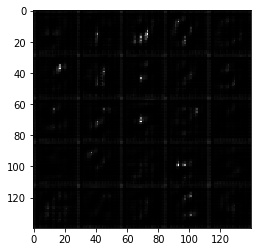

Epoch 1/2... Discriminator Loss: 1.6743... Generator Loss: 0.3816
Epoch 1/2... Discriminator Loss: 1.7303... Generator Loss: 0.3371
Epoch 1/2... Discriminator Loss: 1.7166... Generator Loss: 0.3435
Epoch 1/2... Discriminator Loss: 1.3331... Generator Loss: 0.6571
Epoch 1/2... Discriminator Loss: 1.5323... Generator Loss: 0.4600
Epoch 1/2... Discriminator Loss: 2.0994... Generator Loss: 0.2184
Epoch 1/2... Discriminator Loss: 1.4092... Generator Loss: 0.5357
Epoch 1/2... Discriminator Loss: 1.7493... Generator Loss: 0.3272
Epoch 1/2... Discriminator Loss: 1.3555... Generator Loss: 0.5580
Epoch 1/2... Discriminator Loss: 1.2441... Generator Loss: 1.0503


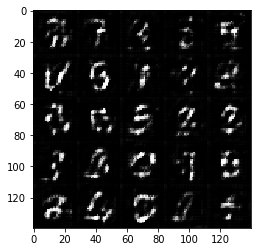

Epoch 1/2... Discriminator Loss: 1.1162... Generator Loss: 1.7290
Epoch 1/2... Discriminator Loss: 1.2843... Generator Loss: 1.6310
Epoch 1/2... Discriminator Loss: 1.4175... Generator Loss: 2.1747
Epoch 1/2... Discriminator Loss: 2.0028... Generator Loss: 2.4057
Epoch 1/2... Discriminator Loss: 1.1428... Generator Loss: 1.7442
Epoch 1/2... Discriminator Loss: 1.2307... Generator Loss: 1.2981
Epoch 1/2... Discriminator Loss: 1.6824... Generator Loss: 2.5913
Epoch 1/2... Discriminator Loss: 1.2706... Generator Loss: 1.9035
Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 1.1582
Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 1.3387


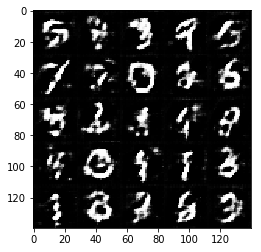

Epoch 1/2... Discriminator Loss: 1.6168... Generator Loss: 0.4548
Epoch 1/2... Discriminator Loss: 1.5099... Generator Loss: 0.4471
Epoch 1/2... Discriminator Loss: 1.7903... Generator Loss: 0.3129
Epoch 1/2... Discriminator Loss: 1.4929... Generator Loss: 0.4421
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.5574
Epoch 1/2... Discriminator Loss: 1.7551... Generator Loss: 0.3126
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 0.6432
Epoch 1/2... Discriminator Loss: 1.5734... Generator Loss: 0.4509
Epoch 1/2... Discriminator Loss: 1.4013... Generator Loss: 0.4988
Epoch 1/2... Discriminator Loss: 1.6206... Generator Loss: 0.3829


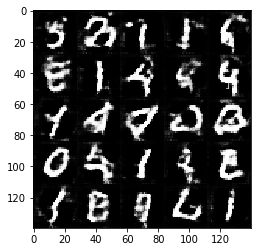

Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 2.0218
Epoch 1/2... Discriminator Loss: 1.2574... Generator Loss: 1.0251
Epoch 1/2... Discriminator Loss: 1.2304... Generator Loss: 0.6358
Epoch 1/2... Discriminator Loss: 1.6656... Generator Loss: 0.3622
Epoch 1/2... Discriminator Loss: 1.4752... Generator Loss: 0.5083
Epoch 1/2... Discriminator Loss: 1.4369... Generator Loss: 0.4811
Epoch 1/2... Discriminator Loss: 1.6718... Generator Loss: 0.3852
Epoch 1/2... Discriminator Loss: 1.6621... Generator Loss: 0.3691
Epoch 1/2... Discriminator Loss: 1.6674... Generator Loss: 0.3491
Epoch 1/2... Discriminator Loss: 1.3542... Generator Loss: 0.9270


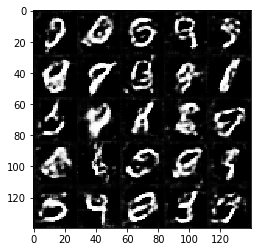

Epoch 1/2... Discriminator Loss: 1.4781... Generator Loss: 1.6724
Epoch 1/2... Discriminator Loss: 1.5325... Generator Loss: 2.0486
Epoch 1/2... Discriminator Loss: 1.4811... Generator Loss: 1.7354
Epoch 1/2... Discriminator Loss: 1.9875... Generator Loss: 0.2468
Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 0.6360
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.5200
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.5906
Epoch 1/2... Discriminator Loss: 1.3048... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 1.1152... Generator Loss: 1.3615
Epoch 1/2... Discriminator Loss: 1.1205... Generator Loss: 1.0848


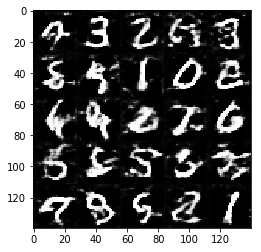

Epoch 1/2... Discriminator Loss: 1.7621... Generator Loss: 0.3613
Epoch 1/2... Discriminator Loss: 1.4938... Generator Loss: 2.3813
Epoch 1/2... Discriminator Loss: 1.2091... Generator Loss: 1.5026
Epoch 1/2... Discriminator Loss: 1.0197... Generator Loss: 1.5405
Epoch 1/2... Discriminator Loss: 1.2235... Generator Loss: 1.6849
Epoch 1/2... Discriminator Loss: 1.2932... Generator Loss: 0.6252
Epoch 1/2... Discriminator Loss: 1.0351... Generator Loss: 0.8473
Epoch 1/2... Discriminator Loss: 1.2226... Generator Loss: 1.8945
Epoch 1/2... Discriminator Loss: 1.1959... Generator Loss: 0.8566
Epoch 1/2... Discriminator Loss: 1.5436... Generator Loss: 0.4354


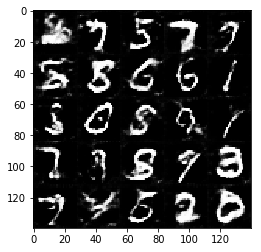

Epoch 1/2... Discriminator Loss: 1.6208... Generator Loss: 0.3762
Epoch 1/2... Discriminator Loss: 1.1898... Generator Loss: 0.8413
Epoch 1/2... Discriminator Loss: 1.4549... Generator Loss: 0.5156
Epoch 1/2... Discriminator Loss: 1.8012... Generator Loss: 0.3253
Epoch 1/2... Discriminator Loss: 1.1504... Generator Loss: 1.7568
Epoch 1/2... Discriminator Loss: 1.0558... Generator Loss: 1.2748
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 1.6864
Epoch 1/2... Discriminator Loss: 1.5474... Generator Loss: 0.4137
Epoch 1/2... Discriminator Loss: 1.6921... Generator Loss: 0.3768
Epoch 1/2... Discriminator Loss: 1.1217... Generator Loss: 1.4319


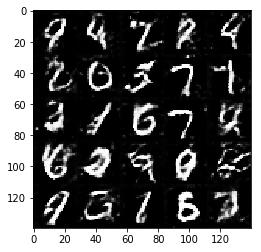

Epoch 1/2... Discriminator Loss: 1.1582... Generator Loss: 1.5516
Epoch 1/2... Discriminator Loss: 1.2056... Generator Loss: 0.7441
Epoch 1/2... Discriminator Loss: 1.6658... Generator Loss: 0.3864
Epoch 1/2... Discriminator Loss: 1.4173... Generator Loss: 0.5178
Epoch 1/2... Discriminator Loss: 1.4798... Generator Loss: 0.4776
Epoch 1/2... Discriminator Loss: 1.4503... Generator Loss: 0.5229
Epoch 1/2... Discriminator Loss: 2.0815... Generator Loss: 0.2713
Epoch 1/2... Discriminator Loss: 1.7071... Generator Loss: 0.3836
Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 2.4062
Epoch 1/2... Discriminator Loss: 1.1479... Generator Loss: 0.7602


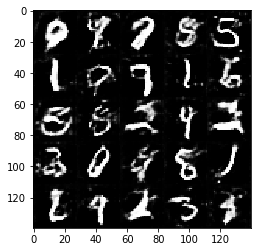

Epoch 1/2... Discriminator Loss: 1.2465... Generator Loss: 0.6780
Epoch 1/2... Discriminator Loss: 1.5351... Generator Loss: 0.4292
Epoch 1/2... Discriminator Loss: 1.5227... Generator Loss: 0.4401
Epoch 2/2... Discriminator Loss: 1.5955... Generator Loss: 0.4478
Epoch 2/2... Discriminator Loss: 1.2495... Generator Loss: 0.7371
Epoch 2/2... Discriminator Loss: 1.1554... Generator Loss: 0.9277
Epoch 2/2... Discriminator Loss: 1.7740... Generator Loss: 0.3301
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.5661
Epoch 2/2... Discriminator Loss: 0.7425... Generator Loss: 2.4493
Epoch 2/2... Discriminator Loss: 1.0471... Generator Loss: 1.7044


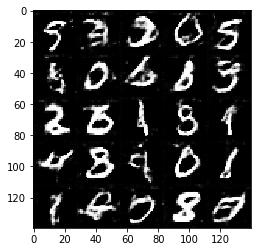

Epoch 2/2... Discriminator Loss: 1.1368... Generator Loss: 0.7395
Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 1.9101
Epoch 2/2... Discriminator Loss: 0.9411... Generator Loss: 0.9600
Epoch 2/2... Discriminator Loss: 1.8051... Generator Loss: 0.4079
Epoch 2/2... Discriminator Loss: 1.2588... Generator Loss: 0.8922
Epoch 2/2... Discriminator Loss: 1.1106... Generator Loss: 1.2402
Epoch 2/2... Discriminator Loss: 1.0517... Generator Loss: 0.9786
Epoch 2/2... Discriminator Loss: 1.2489... Generator Loss: 0.6841
Epoch 2/2... Discriminator Loss: 0.9216... Generator Loss: 1.3218
Epoch 2/2... Discriminator Loss: 1.5403... Generator Loss: 2.7268


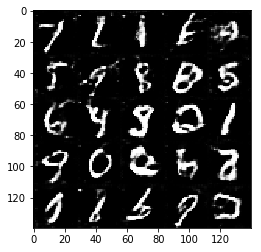

Epoch 2/2... Discriminator Loss: 1.3036... Generator Loss: 0.5680
Epoch 2/2... Discriminator Loss: 1.0283... Generator Loss: 2.0648
Epoch 2/2... Discriminator Loss: 0.7415... Generator Loss: 2.1724
Epoch 2/2... Discriminator Loss: 0.8076... Generator Loss: 1.5171
Epoch 2/2... Discriminator Loss: 2.1534... Generator Loss: 0.2429
Epoch 2/2... Discriminator Loss: 0.9962... Generator Loss: 1.0400
Epoch 2/2... Discriminator Loss: 1.7053... Generator Loss: 0.3867
Epoch 2/2... Discriminator Loss: 1.0252... Generator Loss: 1.4523
Epoch 2/2... Discriminator Loss: 1.0178... Generator Loss: 0.8908
Epoch 2/2... Discriminator Loss: 0.7434... Generator Loss: 2.7488


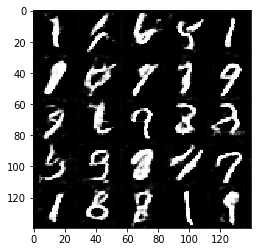

Epoch 2/2... Discriminator Loss: 0.9784... Generator Loss: 0.9481
Epoch 2/2... Discriminator Loss: 1.2124... Generator Loss: 0.7938
Epoch 2/2... Discriminator Loss: 1.4804... Generator Loss: 1.9975
Epoch 2/2... Discriminator Loss: 1.2555... Generator Loss: 1.5037
Epoch 2/2... Discriminator Loss: 1.9663... Generator Loss: 0.3557
Epoch 2/2... Discriminator Loss: 1.0718... Generator Loss: 0.8023
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.5935
Epoch 2/2... Discriminator Loss: 1.0809... Generator Loss: 0.8391
Epoch 2/2... Discriminator Loss: 1.9432... Generator Loss: 0.3120
Epoch 2/2... Discriminator Loss: 1.1159... Generator Loss: 1.4499


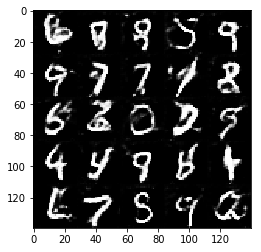

Epoch 2/2... Discriminator Loss: 1.0297... Generator Loss: 1.1670
Epoch 2/2... Discriminator Loss: 1.7395... Generator Loss: 0.3808
Epoch 2/2... Discriminator Loss: 1.7535... Generator Loss: 0.3610
Epoch 2/2... Discriminator Loss: 1.7468... Generator Loss: 0.3684
Epoch 2/2... Discriminator Loss: 0.6247... Generator Loss: 1.7154
Epoch 2/2... Discriminator Loss: 1.8337... Generator Loss: 0.3679
Epoch 2/2... Discriminator Loss: 1.0110... Generator Loss: 1.1470
Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 1.3015
Epoch 2/2... Discriminator Loss: 2.6771... Generator Loss: 0.2062
Epoch 2/2... Discriminator Loss: 1.8187... Generator Loss: 0.3387


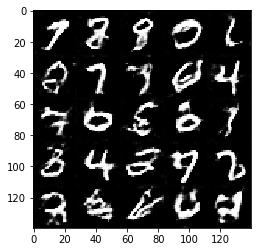

Epoch 2/2... Discriminator Loss: 0.8214... Generator Loss: 1.3762
Epoch 2/2... Discriminator Loss: 1.4105... Generator Loss: 0.5667
Epoch 2/2... Discriminator Loss: 1.8810... Generator Loss: 0.3843
Epoch 2/2... Discriminator Loss: 0.7733... Generator Loss: 1.9675
Epoch 2/2... Discriminator Loss: 1.0463... Generator Loss: 0.9299
Epoch 2/2... Discriminator Loss: 2.0316... Generator Loss: 0.5070
Epoch 2/2... Discriminator Loss: 1.4256... Generator Loss: 0.5437
Epoch 2/2... Discriminator Loss: 1.2532... Generator Loss: 2.2888
Epoch 2/2... Discriminator Loss: 1.0765... Generator Loss: 1.1079
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 2.6409


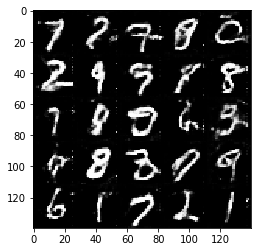

Epoch 2/2... Discriminator Loss: 1.2660... Generator Loss: 0.5793
Epoch 2/2... Discriminator Loss: 2.3381... Generator Loss: 0.2285
Epoch 2/2... Discriminator Loss: 1.1169... Generator Loss: 0.7760
Epoch 2/2... Discriminator Loss: 1.5312... Generator Loss: 0.5594
Epoch 2/2... Discriminator Loss: 0.6521... Generator Loss: 2.0973
Epoch 2/2... Discriminator Loss: 0.6610... Generator Loss: 1.5204
Epoch 2/2... Discriminator Loss: 1.7672... Generator Loss: 0.5053
Epoch 2/2... Discriminator Loss: 1.0834... Generator Loss: 2.0686
Epoch 2/2... Discriminator Loss: 0.9547... Generator Loss: 0.9830
Epoch 2/2... Discriminator Loss: 0.8228... Generator Loss: 2.2161


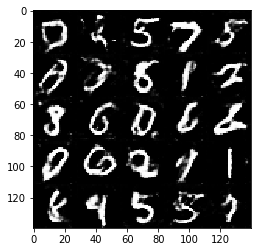

Epoch 2/2... Discriminator Loss: 0.8335... Generator Loss: 1.1461
Epoch 2/2... Discriminator Loss: 0.6888... Generator Loss: 1.9494
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.6035
Epoch 2/2... Discriminator Loss: 1.4850... Generator Loss: 0.4863
Epoch 2/2... Discriminator Loss: 1.2264... Generator Loss: 0.8176
Epoch 2/2... Discriminator Loss: 0.8476... Generator Loss: 1.2258
Epoch 2/2... Discriminator Loss: 1.1612... Generator Loss: 0.8545
Epoch 2/2... Discriminator Loss: 2.9140... Generator Loss: 4.2840
Epoch 2/2... Discriminator Loss: 0.8633... Generator Loss: 1.2573
Epoch 2/2... Discriminator Loss: 0.7352... Generator Loss: 1.9597


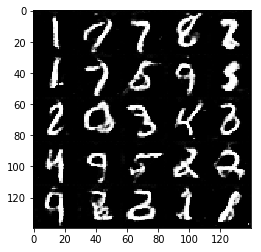

Epoch 2/2... Discriminator Loss: 1.5789... Generator Loss: 0.5176
Epoch 2/2... Discriminator Loss: 0.6518... Generator Loss: 1.6969
Epoch 2/2... Discriminator Loss: 0.7662... Generator Loss: 1.4223
Epoch 2/2... Discriminator Loss: 0.8049... Generator Loss: 1.1994
Epoch 2/2... Discriminator Loss: 1.1742... Generator Loss: 1.1565
Epoch 2/2... Discriminator Loss: 1.2862... Generator Loss: 0.6221
Epoch 2/2... Discriminator Loss: 1.1013... Generator Loss: 1.4542
Epoch 2/2... Discriminator Loss: 1.3024... Generator Loss: 1.8331
Epoch 2/2... Discriminator Loss: 1.2130... Generator Loss: 0.7206
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 1.3425


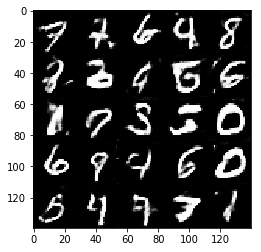

Epoch 2/2... Discriminator Loss: 1.2512... Generator Loss: 0.6822
Epoch 2/2... Discriminator Loss: 0.8726... Generator Loss: 1.9386
Epoch 2/2... Discriminator Loss: 1.2886... Generator Loss: 0.6415
Epoch 2/2... Discriminator Loss: 1.1687... Generator Loss: 0.7089
Epoch 2/2... Discriminator Loss: 0.5991... Generator Loss: 1.7821
Epoch 2/2... Discriminator Loss: 1.2351... Generator Loss: 0.7594
Epoch 2/2... Discriminator Loss: 0.6112... Generator Loss: 2.0154


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.4468... Generator Loss: 0.2745
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.5556
Epoch 1/1... Discriminator Loss: 2.3631... Generator Loss: 0.1687
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 2.0072
Epoch 1/1... Discriminator Loss: 2.2261... Generator Loss: 0.2314
Epoch 1/1... Discriminator Loss: 1.7511... Generator Loss: 0.3601
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.6859


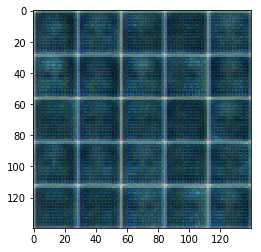

Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 1.7484
Epoch 1/1... Discriminator Loss: 2.1676... Generator Loss: 0.2416
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.6611... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.6834... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.4988
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.6064... Generator Loss: 1.1592
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.8361


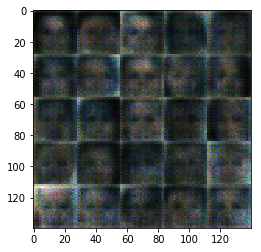

Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 0.4376
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 1.1503
Epoch 1/1... Discriminator Loss: 1.6991... Generator Loss: 0.3823
Epoch 1/1... Discriminator Loss: 1.7149... Generator Loss: 1.5564
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.5686


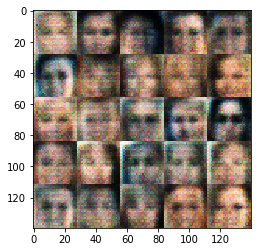

Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 1.6577
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 1.3021
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 1.5470... Generator Loss: 0.4072
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.4179
Epoch 1/1... Discriminator Loss: 1.7080... Generator Loss: 0.3498
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 1.4431
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.9721... Generator Loss: 0.2651


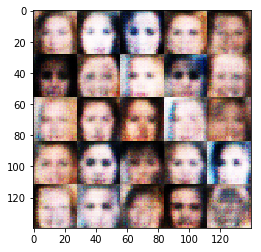

Epoch 1/1... Discriminator Loss: 1.6871... Generator Loss: 0.3775
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 2.2694
Epoch 1/1... Discriminator Loss: 1.5928... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 1.0151
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 1.1469
Epoch 1/1... Discriminator Loss: 1.6656... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.6611


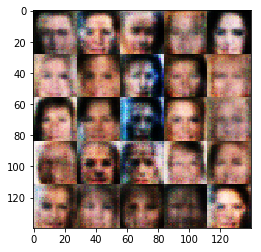

Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.5655... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.5838... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.6917


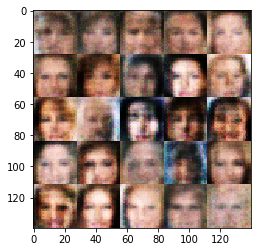

Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8106


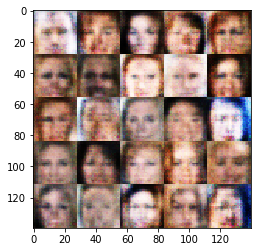

Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6709


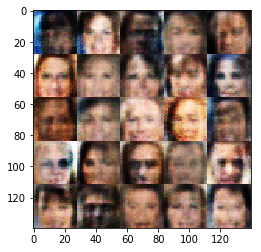

Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.6970


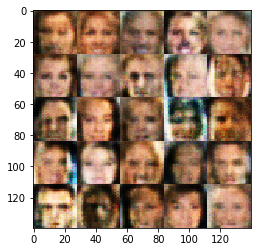

Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.8789


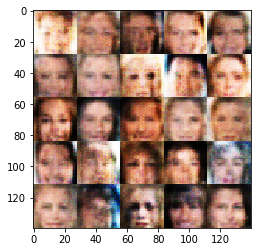

Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 1.2735
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6727
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 1.2208
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.6504... Generator Loss: 0.3879
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.6403


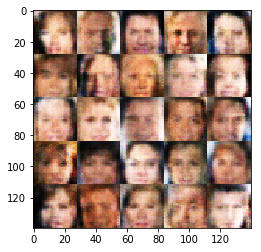

Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 1.5747
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 0.9776... Generator Loss: 1.4145
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.3627
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 1.9201
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 2.0275
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 1.6371


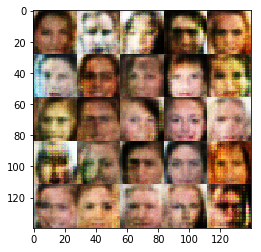

Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 2.1735
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 2.0450
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 1.5961
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.7314... Generator Loss: 0.3177
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.4869


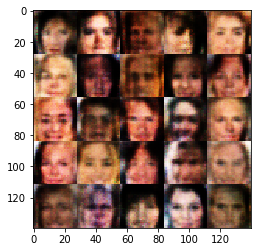

Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.6992... Generator Loss: 0.3195
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 2.9133
Epoch 1/1... Discriminator Loss: 1.6222... Generator Loss: 1.6731
Epoch 1/1... Discriminator Loss: 1.7078... Generator Loss: 0.3616
Epoch 1/1... Discriminator Loss: 1.7247... Generator Loss: 0.3498
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 1.4342
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 1.0537
Epoch 1/1... Discriminator Loss: 1.8839... Generator Loss: 0.2615
Epoch 1/1... Discriminator Loss: 1.9268... Generator Loss: 0.2366


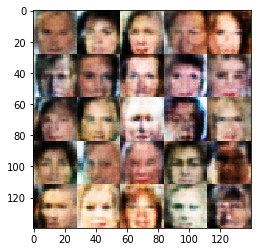

Epoch 1/1... Discriminator Loss: 1.5981... Generator Loss: 0.3680
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.4392
Epoch 1/1... Discriminator Loss: 1.1874... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 2.5870
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 2.1948
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 1.9718
Epoch 1/1... Discriminator Loss: 0.6294... Generator Loss: 3.0125
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.5032


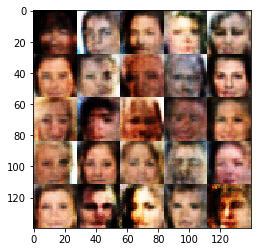

Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 1.8174
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.6101... Generator Loss: 0.3597
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 0.6018... Generator Loss: 2.4114
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.5778


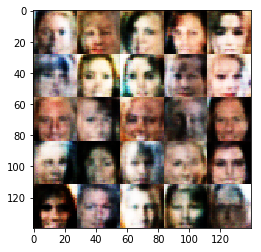

Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 3.3299
Epoch 1/1... Discriminator Loss: 0.6063... Generator Loss: 2.7668
Epoch 1/1... Discriminator Loss: 0.6203... Generator Loss: 2.6448
Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.1432
Epoch 1/1... Discriminator Loss: 0.6449... Generator Loss: 1.9993
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 5.6446
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 2.5766
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 5.4098
Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 0.4088


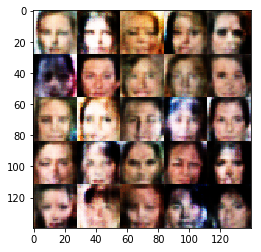

Epoch 1/1... Discriminator Loss: 0.5804... Generator Loss: 2.2101
Epoch 1/1... Discriminator Loss: 0.5930... Generator Loss: 3.8287
Epoch 1/1... Discriminator Loss: 1.5630... Generator Loss: 0.4096
Epoch 1/1... Discriminator Loss: 0.6346... Generator Loss: 2.3035
Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 4.2356
Epoch 1/1... Discriminator Loss: 0.5754... Generator Loss: 1.8226
Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 3.8573
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.4192


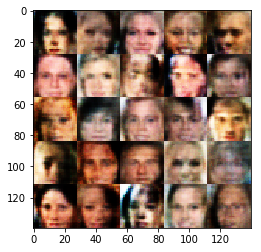

Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.4560
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.5665
Epoch 1/1... Discriminator Loss: 0.7779... Generator Loss: 3.8992
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 1.9149
Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 4.1079
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 2.6185
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 1.5533
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 1.2950


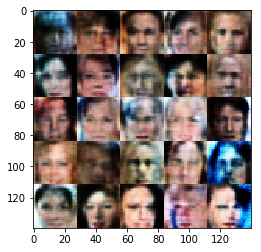

Epoch 1/1... Discriminator Loss: 0.5626... Generator Loss: 2.1434
Epoch 1/1... Discriminator Loss: 0.7784... Generator Loss: 3.7381
Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 2.4168
Epoch 1/1... Discriminator Loss: 0.9825... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 0.5533... Generator Loss: 2.7538
Epoch 1/1... Discriminator Loss: 1.6640... Generator Loss: 3.6079
Epoch 1/1... Discriminator Loss: 0.5481... Generator Loss: 2.1300
Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 0.7387... Generator Loss: 2.6039
Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 2.2553


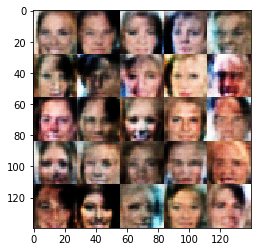

Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 0.9638
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 0.4724... Generator Loss: 3.5033
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.5425
Epoch 1/1... Discriminator Loss: 0.6769... Generator Loss: 1.4821
Epoch 1/1... Discriminator Loss: 0.6670... Generator Loss: 1.6299
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 0.5177... Generator Loss: 3.1158
Epoch 1/1... Discriminator Loss: 0.5866... Generator Loss: 4.5676


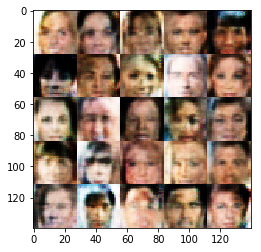

Epoch 1/1... Discriminator Loss: 0.6091... Generator Loss: 2.7198
Epoch 1/1... Discriminator Loss: 0.7028... Generator Loss: 2.9971
Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 2.1796
Epoch 1/1... Discriminator Loss: 0.4990... Generator Loss: 3.3294
Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 2.8069
Epoch 1/1... Discriminator Loss: 1.7426... Generator Loss: 3.2499
Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 2.1502
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 2.7010
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 1.2336
Epoch 1/1... Discriminator Loss: 0.7402... Generator Loss: 3.6375


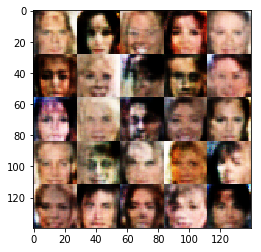

Epoch 1/1... Discriminator Loss: 0.5376... Generator Loss: 2.7363
Epoch 1/1... Discriminator Loss: 0.5005... Generator Loss: 2.2553
Epoch 1/1... Discriminator Loss: 0.7016... Generator Loss: 1.3346
Epoch 1/1... Discriminator Loss: 0.4034... Generator Loss: 3.2644
Epoch 1/1... Discriminator Loss: 0.5715... Generator Loss: 1.8187
Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 2.6161
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 2.2439
Epoch 1/1... Discriminator Loss: 0.4778... Generator Loss: 2.9005
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.0625
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 3.1518


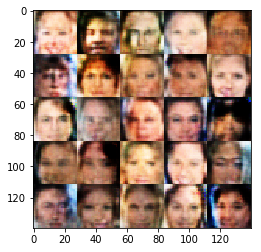

Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 2.9773
Epoch 1/1... Discriminator Loss: 0.4856... Generator Loss: 3.8721
Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 1.1474
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 3.1534
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 2.9068
Epoch 1/1... Discriminator Loss: 0.5953... Generator Loss: 1.7241
Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 4.7647
Epoch 1/1... Discriminator Loss: 0.6591... Generator Loss: 1.4606
Epoch 1/1... Discriminator Loss: 0.5567... Generator Loss: 1.8434
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 0.9685


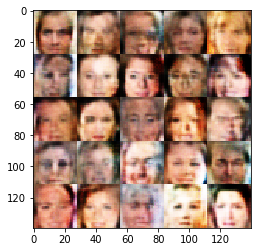

Epoch 1/1... Discriminator Loss: 0.4682... Generator Loss: 2.5135
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.0032
Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 2.4648
Epoch 1/1... Discriminator Loss: 0.8120... Generator Loss: 1.0915
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 0.4555... Generator Loss: 3.7073
Epoch 1/1... Discriminator Loss: 2.6069... Generator Loss: 4.0216
Epoch 1/1... Discriminator Loss: 0.5691... Generator Loss: 2.1323
Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 1.7397
Epoch 1/1... Discriminator Loss: 0.5550... Generator Loss: 1.7952


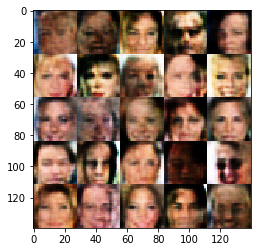

Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 1.8144
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 2.4567
Epoch 1/1... Discriminator Loss: 0.4057... Generator Loss: 2.8507
Epoch 1/1... Discriminator Loss: 0.4058... Generator Loss: 3.5129
Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 2.5887
Epoch 1/1... Discriminator Loss: 0.4011... Generator Loss: 4.2523
Epoch 1/1... Discriminator Loss: 0.4919... Generator Loss: 2.2542
Epoch 1/1... Discriminator Loss: 0.4429... Generator Loss: 3.1630
Epoch 1/1... Discriminator Loss: 0.5125... Generator Loss: 2.2297
Epoch 1/1... Discriminator Loss: 0.5217... Generator Loss: 2.2105


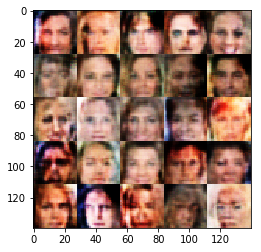

Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 2.9399
Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 3.6500
Epoch 1/1... Discriminator Loss: 0.5086... Generator Loss: 2.0533
Epoch 1/1... Discriminator Loss: 0.8142... Generator Loss: 5.8857
Epoch 1/1... Discriminator Loss: 0.4340... Generator Loss: 3.6551
Epoch 1/1... Discriminator Loss: 0.4080... Generator Loss: 4.2292
Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 2.5178
Epoch 1/1... Discriminator Loss: 0.4781... Generator Loss: 5.7488
Epoch 1/1... Discriminator Loss: 0.5640... Generator Loss: 1.8295
Epoch 1/1... Discriminator Loss: 0.3537... Generator Loss: 4.9133


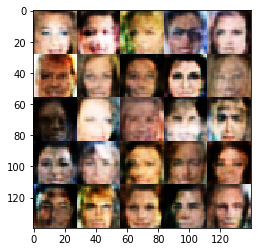

Epoch 1/1... Discriminator Loss: 0.4364... Generator Loss: 3.0888
Epoch 1/1... Discriminator Loss: 0.4797... Generator Loss: 2.3514
Epoch 1/1... Discriminator Loss: 0.3958... Generator Loss: 3.5877
Epoch 1/1... Discriminator Loss: 0.4126... Generator Loss: 5.0665
Epoch 1/1... Discriminator Loss: 0.4419... Generator Loss: 2.5260
Epoch 1/1... Discriminator Loss: 0.3680... Generator Loss: 4.5002
Epoch 1/1... Discriminator Loss: 0.4831... Generator Loss: 2.1715
Epoch 1/1... Discriminator Loss: 0.5207... Generator Loss: 3.9811
Epoch 1/1... Discriminator Loss: 0.3767... Generator Loss: 4.1555
Epoch 1/1... Discriminator Loss: 0.3832... Generator Loss: 3.8633


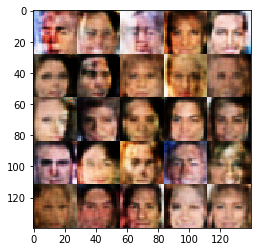

Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 2.5913
Epoch 1/1... Discriminator Loss: 0.3819... Generator Loss: 4.2349
Epoch 1/1... Discriminator Loss: 0.4734... Generator Loss: 2.7014
Epoch 1/1... Discriminator Loss: 0.3710... Generator Loss: 4.4827
Epoch 1/1... Discriminator Loss: 0.4642... Generator Loss: 2.6191
Epoch 1/1... Discriminator Loss: 0.4166... Generator Loss: 2.8632
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 4.4134
Epoch 1/1... Discriminator Loss: 0.3881... Generator Loss: 3.9227
Epoch 1/1... Discriminator Loss: 0.4518... Generator Loss: 2.9652
Epoch 1/1... Discriminator Loss: 0.3754... Generator Loss: 4.5652


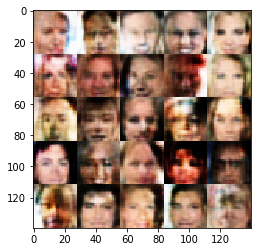

Epoch 1/1... Discriminator Loss: 0.3747... Generator Loss: 3.4700
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 2.2568
Epoch 1/1... Discriminator Loss: 0.5429... Generator Loss: 2.0142
Epoch 1/1... Discriminator Loss: 0.3632... Generator Loss: 4.1927
Epoch 1/1... Discriminator Loss: 0.5551... Generator Loss: 4.8607
Epoch 1/1... Discriminator Loss: 0.4304... Generator Loss: 3.4620
Epoch 1/1... Discriminator Loss: 0.5472... Generator Loss: 1.9292
Epoch 1/1... Discriminator Loss: 0.4013... Generator Loss: 4.7901
Epoch 1/1... Discriminator Loss: 0.3948... Generator Loss: 3.1916
Epoch 1/1... Discriminator Loss: 0.5778... Generator Loss: 1.9868


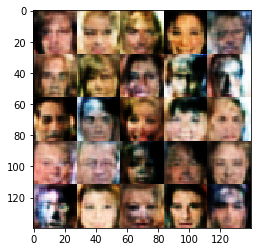

Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 3.4614
Epoch 1/1... Discriminator Loss: 0.3575... Generator Loss: 4.5007
Epoch 1/1... Discriminator Loss: 0.4718... Generator Loss: 2.4193
Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 3.6589
Epoch 1/1... Discriminator Loss: 0.4472... Generator Loss: 4.3195
Epoch 1/1... Discriminator Loss: 1.7119... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 0.3944... Generator Loss: 4.2256
Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 3.8117
Epoch 1/1... Discriminator Loss: 0.3802... Generator Loss: 3.5735
Epoch 1/1... Discriminator Loss: 0.5907... Generator Loss: 1.7291


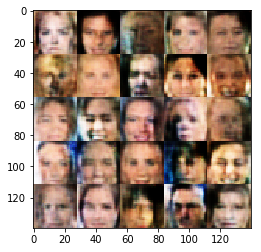

Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 4.5935
Epoch 1/1... Discriminator Loss: 0.3750... Generator Loss: 3.6975
Epoch 1/1... Discriminator Loss: 0.4855... Generator Loss: 2.1848
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 0.4313... Generator Loss: 2.8881
Epoch 1/1... Discriminator Loss: 0.5319... Generator Loss: 2.0484


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.